# Capital Bike Share Diaries: Data Mining Project

## 1. Introduction

### 1.1. Project Overview
* Briefly describe the project's goal (analyzing daily bike trips in Washington D.C.).

### 1.2. Objectives
* List the main objectives as stated in the document (understanding usage patterns, weather impact, high activity zones, etc.).

### 1.3. Datasets
* List the datasets to be used (Daily Bikes Trips, Daily Weather Info, Stations Info, etc.).

### 1.4. Tools and Libraries
* Mention the programming language (Python) and permitted frameworks (Pandas, NumPy, Plotly, Scikit-Learn, etc.).

## 2. Setup Environment

#### 2.0.1 Mounting Drive

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 2.0.2 Installing Libraries

In [4]:
%%capture
!pip install geopandas
!pip install -U shapely pyproj rtree
!pip install pygeohash
!pip install missingno
!pip install folium


### 2.1. Import Libraries

In [5]:
# Import necessary libraries
import os

import pandas as pd
import numpy as np
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import folium
import pygeohash
import missingno as msno
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
# from prophet import Prophet # Uncomment if using Prophet
import datetime
import math

### 2.2. Load Datasets
* Load each dataset into pandas/geopandas DataFrames.
* Display the head and info for each dataset to get a first look.

In [14]:
data_folder_path = "/content/drive/MyDrive/Data Mining Homework/Homework 01/data"

# List the files in the data folder
files = [f for f in os.listdir(data_folder_path) if os.path.isfile(os.path.join(data_folder_path, f))]

# Create a dictionary to store dataframes
dataframes = {}

# Load each file into a pandas DataFrame
for file_name in files:
    file_path = os.path.join(data_folder_path, file_name)
    try:
        df_name = os.path.splitext(file_name)[0] # Use filename without extension as dataframe key
        if file_name.endswith('.csv'):
            dataframes[df_name] = pd.read_csv(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        elif file_name.endswith('.parquet'):
            dataframes[df_name] = pd.read_parquet(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        elif file_name.endswith('.geojson'):
            # You might need to install geopandas: pip install geopandas
            dataframes[df_name] = gpd.read_file(file_path)
            print(f"Successfully loaded {file_name} into dataframe '{df_name}'")
        else:
            print(f"Skipping unknown file type: {file_name}")
    except Exception as e:
        print(f"Error loading {file_name}: {e}")

Successfully loaded DDOT_Central_Business_District.geojson into dataframe 'DDOT_Central_Business_District'
Successfully loaded Residential_and_Visitor_Parking_Zones.geojson into dataframe 'Residential_and_Visitor_Parking_Zones'
Successfully loaded Capital_Bikeshare_Locations.csv into dataframe 'Capital_Bikeshare_Locations'
Successfully loaded Washington,DC,USA 2024-01-01 to 2024-12-31.csv into dataframe 'Washington,DC,USA 2024-01-01 to 2024-12-31'
Successfully loaded Metro_Bus_Stops.csv into dataframe 'Metro_Bus_Stops'
Successfully loaded Shuttle_Bus_Stops.csv into dataframe 'Shuttle_Bus_Stops'
Successfully loaded stations.csv into dataframe 'stations'
Successfully loaded daily-rent-sampled.parquet into dataframe 'daily-rent-sampled'
Successfully loaded daily-rent.parquet into dataframe 'daily-rent'


Data Frames names:
- Daily Bikes Trips
- Daily Weather Info
- Stations Info Dataset
- Stations Table
- CBD Polygon
- Metro Bus Stops
- Shuttle Bus Stops
- Residential and Visitor Parking Zones

In [15]:
stations_info_df = dataframes['Capital_Bikeshare_Locations']
metro_bus_stops_df = dataframes['Metro_Bus_Stops']
shuttle_bus_stops_df = dataframes['Shuttle_Bus_Stops']
daily_weather_info_df = dataframes['Washington,DC,USA 2024-01-01 to 2024-12-31']
# daily_bikes_trips_df = pd.concat([dataframes['daily-rent'], dataframes['daily-rent-sampled']], ignore_index=True)
daily_bikes_trips_df=dataframes['daily-rent']
daily_bikes_trips_sambel_df=dataframes['daily-rent-sampled']
stations_table_df = dataframes['stations']
cbd_polygon_df = dataframes['DDOT_Central_Business_District']
residential_and_visitor_parking_zones_df = dataframes['Residential_and_Visitor_Parking_Zones']

## 3. Data Cleaning and Integration (Preprocessing)

### 3.1. Initial Data Inspection
* Check for missing values (`.isnull().sum()`).
* Check data types (`.dtypes`).
* Check for duplicates (`.duplicated().sum()`).
* Basic descriptive statistics (`.describe(include='all')`).

##### 3.1.1 For Daily Bikes Trips


###### Data Info

In [16]:
daily_bikes_trips_df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,1st & O St NW,31519,4th & College St NW,31138,38.908643,-77.012365,38.921233,-77.018135,member
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,1st & O St NW,31519,1st & L St NW,31677,38.908643,-77.012365,38.903819,-77.011987,member
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,1st & O St NW,31519,10th & G St NW,31274,38.908690,-77.012317,38.898243,-77.026235,casual


In [17]:
daily_bikes_trips_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6114323 entries, 0 to 6114322
Data columns (total 13 columns):
 #   Column              Dtype         
---  ------              -----         
 0   ride_id             string        
 1   rideable_type       string        
 2   started_at          datetime64[ns]
 3   ended_at            datetime64[ns]
 4   start_station_name  string        
 5   start_station_id    string        
 6   end_station_name    string        
 7   end_station_id      string        
 8   start_lat           float64       
 9   start_lng           float64       
 10  end_lat             float64       
 11  end_lng             float64       
 12  member_casual       string        
dtypes: datetime64[ns](2), float64(4), string(7)
memory usage: 606.4 MB


In [18]:
daily_bikes_trips_df.describe(include='all')

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
count,6114323,6114323,6114323,6114323,4923357,4923357,4878156,4876629,6.114323e+06,6.114323e+06,6.109673e+06,6.109673e+06,6114323
unique,6114182,2,NaN,NaN,818,803,818,803,NaN,NaN,NaN,NaN,2
top,3A14268683BA3FCE,electric_bike,NaN,NaN,Columbus Circle / Union Station,31623,Columbus Circle / Union Station,31623,NaN,NaN,NaN,NaN,member
freq,2,3404885,NaN,NaN,55508,55508,55458,55437,NaN,NaN,NaN,NaN,4059247
mean,NaN,NaN,2024-07-18 16:52:01.082998016,2024-07-18 18:43:22.552895744,NaN,NaN,NaN,NaN,3.890560e+01,-7.703176e+01,3.890488e+01,-7.703157e+01,NaN
min,NaN,NaN,1970-01-01 00:00:00,2000-01-01 15:55:56,NaN,NaN,NaN,NaN,-8.960010e+01,-1.716215e+02,-8.839068e+01,-1.723373e+02,NaN
25%,NaN,NaN,2024-05-03 10:55:45.500000,2024-05-03 11:15:35.500000,NaN,NaN,NaN,NaN,3.889287e+01,-7.704440e+01,3.889227e+01,-7.704442e+01,NaN
50%,NaN,NaN,2024-07-26 11:27:16.340999936,2024-07-26 11:47:01.260000,NaN,NaN,NaN,NaN,3.890550e+01,-7.703000e+01,3.890383e+01,-7.703000e+01,NaN
75%,NaN,NaN,2024-10-06 17:20:19.227500032,2024-10-06 17:41:45.916499968,NaN,NaN,NaN,NaN,3.891902e+01,-7.701162e+01,3.891776e+01,-7.701082e+01,NaN
max,NaN,NaN,2024-12-31 23:54:46.421000,2030-01-01 00:00:00,NaN,NaN,NaN,NaN,8.582003e+01,5.993410e+01,8.957352e+01,5.730187e+01,NaN


###### Unique Values

In [19]:
daily_bikes_trips_df.nunique()

,0
ride_id,6114182
rideable_type,2
started_at,5866403
ended_at,5869571
start_station_name,818
start_station_id,803
end_station_name,818
end_station_id,803
start_lat,468450
start_lng,501510


###### Duplicated Rows

In [20]:
print(daily_bikes_trips_df.duplicated().sum())

0


###### Null Values

In [21]:
print(daily_bikes_trips_df.isnull().sum())

ride_id                     0
rideable_type               0
started_at                  0
ended_at                    0
start_station_name    1190966
start_station_id      1190966
end_station_name      1236167
end_station_id        1237694
start_lat                   0
start_lng                   0
end_lat                  4650
end_lng                  4650
member_casual               0
dtype: int64


<Axes: >

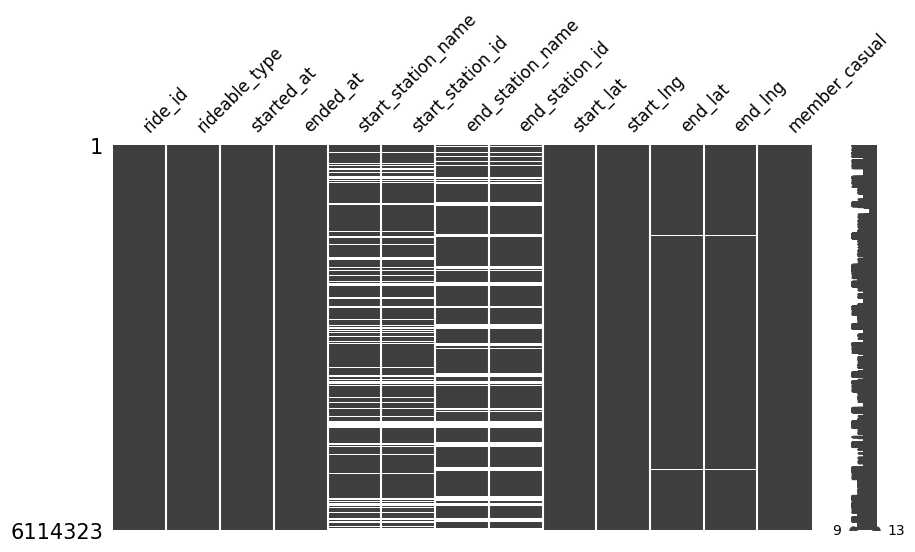

In [22]:
msno.matrix(daily_bikes_trips_df, figsize=(10,5), fontsize=12)

<Axes: >

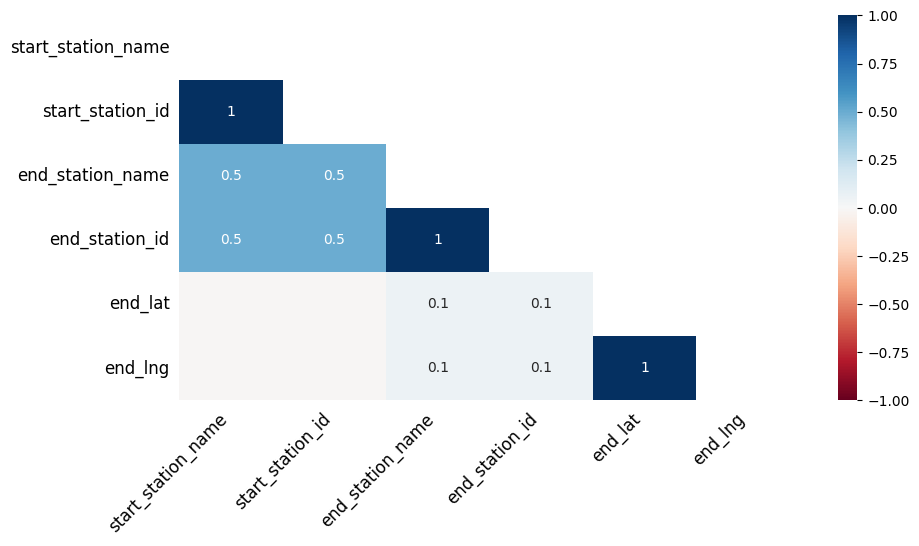

In [23]:
msno.heatmap(daily_bikes_trips_df,figsize=(10,5), fontsize=12)

<Axes: >

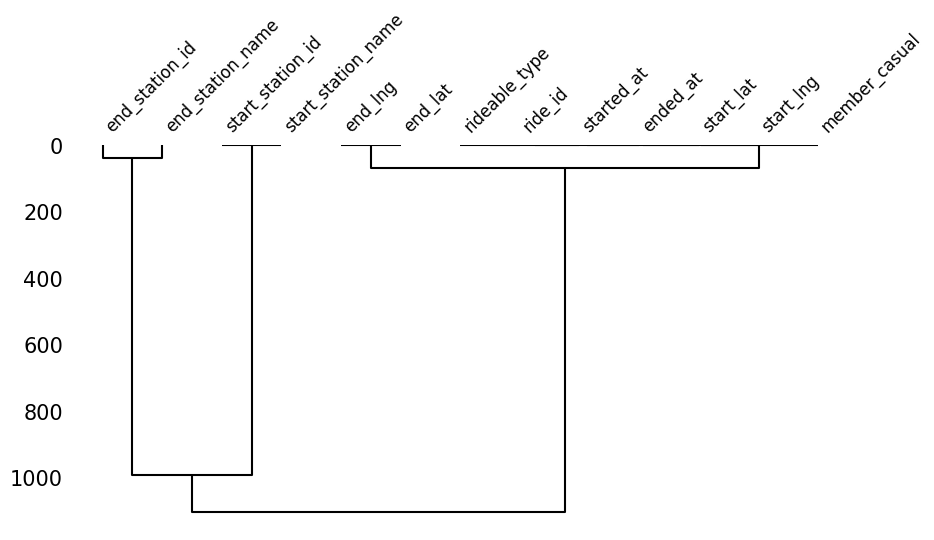

In [24]:
msno.dendrogram(daily_bikes_trips_df,figsize=(10,5), fontsize=12)

###### Summary

- There are no duplicate rows
- Whenever end_lat and end_lng are missing, end_station_name and end_station_id are also missing for those same rows

##### 3.1.2 For Stations Table


###### Data Info

In [25]:
stations_table_df.head()

,id,name
0,30200,9th St & Pennsylvania Ave NW
1,30201,9th & G St NW
2,31000,Eads St & 15th St S
3,31002,Crystal Dr & 20th St S
4,31003,Crystal Dr & 15th St S


In [26]:
stations_table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 821 entries, 0 to 820
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      821 non-null    int64 
 1   name    821 non-null    object
dtypes: int64(1), object(1)
memory usage: 13.0+ KB


In [27]:
stations_table_df.describe(include='all')

,id,name
count,821.000000,821
unique,NaN,820
top,NaN,Randle Circle & Minnesota Ave SE
freq,NaN,2
mean,31650.894032,NaN
std,447.232558,NaN
min,30200.000000,NaN
25%,31263.000000,NaN
50%,31630.000000,NaN
75%,32022.000000,NaN


###### Unique Values

In [28]:
stations_table_df.nunique()

,0
id,804
name,820


In [29]:
rows_with_non_unique_name = stations_table_df[stations_table_df.duplicated(subset=['name'], keep=False)]
print("Rows with non-unique Names:")
rows_with_non_unique_name

Rows with non-unique Names:


,id,name
465,31702,Randle Circle & Minnesota Ave SE
492,31799,Randle Circle & Minnesota Ave SE


In [30]:
rows_with_non_unique_id = stations_table_df[stations_table_df.duplicated(subset=['id'], keep=False)]
print("Rows with non-unique IDs:")
rows_with_non_unique_id

Rows with non-unique IDs:


,id,name
45,31045,S Payne St & King St
46,31045,Commerce St & Fayette St
133,31133,20th & Columbia Rd NW
134,31133,20th St & Columbia Rd NW
135,31133,19th St & Wyoming Ave NW
166,31225,C & O Canal & Wisconsin Ave NW
167,31225,Wisconsin Ave & K St NW
281,31339,18th St & Ingleside Terr NW
282,31339,18th St & Ingleside Ter NW
284,31380,Roland Clarke Pl & Sunrise Valley Dr


###### Duplicated Rows

In [31]:
print(stations_table_df.duplicated().sum())

0


###### Null Values

In [32]:
print(stations_table_df.isnull().sum())

id      0
name    0
dtype: int64


###### Summary

- There is one name duplicated "Randle Circle & Minnesota Ave SE", and 17 IDs duplicated.
- There are no missing values

##### 3.1.3 For Stations Info

###### Data Info

In [33]:
stations_info_df.head()

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
0,-8.577104e+06,4.705679e+06,Lincoln Memorial,classic,08254284-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,17,0,8,...,NO,25,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888255,-77.049437,2025/05/05 20:27:29+00,261284028
1,-8.609481e+06,4.714716e+06,W&OD Trail/Sunset Hills Rd & Isaac Newton Sq,classic,08263fbd-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,15,0,3,...,NO,19,"KEY,CREDITCARD",104.0,DCA-CABI,NaN,38.951419,-77.340281,2025/05/05 20:27:29+00,261284029
2,-8.575867e+06,4.705657e+06,17th St & Independence Ave SW,classic,082623bf-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:51+00,10,0,6,...,NO,19,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.888097,-77.038325,2025/05/05 20:27:29+00,261284030
3,-8.574188e+06,4.706622e+06,8th & D St NW,classic,08256ac9-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,0,0,24,...,NO,24,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.894851,-77.023240,2025/05/05 20:27:29+00,261284031
4,-8.567161e+06,4.706864e+06,Anacostia Ave & Benning Rd NE / River Terrace,classic,082518eb-1f3f-11e7-bf6b-3863bb334450,NaN,2025/05/05 20:25:49+00,4,0,10,...,NO,15,"KEY,CREDITCARD",42.0,DCA-CABI,NaN,38.896544,-76.960120,2025/05/05 20:27:29+00,261284032


In [34]:
stations_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   X                               794 non-null    float64
 1   Y                               794 non-null    float64
 2   NAME                            794 non-null    object 
 3   STATION_TYPE                    794 non-null    object 
 4   STATION_ID                      794 non-null    object 
 5   STATION_STATUS                  0 non-null      float64
 6   LAST_REPORTED                   794 non-null    object 
 7   NUM_DOCKS_AVAILABLE             794 non-null    int64  
 8   NUM_DOCKS_DISABLED              794 non-null    int64  
 9   NUM_BIKES_AVAILABLE             794 non-null    int64  
 10  NUM_EBIKES_AVAILABLE            794 non-null    int64  
 11  NUM_BIKES_DISABLED              794 non-null    int64  
 12  IS_INSTALLED                    794 

In [35]:
stations_info_df.describe(include='all')

,X,Y,NAME,STATION_TYPE,STATION_ID,STATION_STATUS,LAST_REPORTED,NUM_DOCKS_AVAILABLE,NUM_DOCKS_DISABLED,NUM_BIKES_AVAILABLE,...,EIGHTD_HAS_KEY_DISPENSER,CAPACITY,RENTAL_METHODS,REGION_ID,REGION_NAME,GIS_ID,LATITUDE,LONGITUDE,GIS_LAST_MOD_DTTM,OBJECTID
count,7.940000e+02,7.940000e+02,794,794,794,0.0,794,794.00000,794.000000,794.000000,...,794,794.000000,794,744.000000,794,0.0,794.000000,794.000000,794,7.940000e+02
unique,NaN,NaN,794,1,794,NaN,125,NaN,NaN,NaN,...,1,NaN,1,NaN,1,NaN,NaN,NaN,2,NaN
top,NaN,NaN,Old Meadow Rd & Cathy Ln,classic,1890899920583743818,NaN,2025/05/05 20:26:08+00,NaN,NaN,NaN,...,NO,NaN,"KEY,CREDITCARD",NaN,DCA-CABI,NaN,NaN,NaN,2025/05/05 20:27:29+00,NaN
freq,NaN,NaN,1,794,1,NaN,14,NaN,NaN,NaN,...,794,NaN,794,NaN,794,NaN,NaN,NaN,604,NaN
mean,-8.579029e+06,4.708386e+06,NaN,NaN,NaN,NaN,NaN,10.13728,0.021411,6.419395,...,NaN,17.234257,NaN,53.034946,NaN,NaN,38.907156,-77.066727,NaN,2.612862e+08
std,1.073636e+04,8.392150e+03,NaN,NaN,NaN,NaN,NaN,6.07810,0.271923,5.968744,...,NaN,5.712581,NaN,27.714636,NaN,NaN,0.058643,0.096446,NaN,3.217789e+03
min,-8.614982e+06,4.688330e+06,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,0.000000,...,NaN,8.000000,NaN,40.000000,NaN,NaN,38.766844,-77.389696,NaN,2.612840e+08
25%,-8.582008e+06,4.704036e+06,NaN,NaN,NaN,NaN,NaN,5.00000,0.000000,2.000000,...,NaN,15.000000,NaN,42.000000,NaN,NaN,38.876769,-77.093483,NaN,2.612842e+08
50%,-8.576564e+06,4.707386e+06,NaN,NaN,NaN,NaN,NaN,10.00000,0.000000,5.000000,...,NaN,15.000000,NaN,42.000000,NaN,NaN,38.900192,-77.044581,NaN,2.612844e+08
75%,-8.572478e+06,4.711950e+06,NaN,NaN,NaN,NaN,NaN,14.00000,0.000000,10.000000,...,NaN,19.000000,NaN,43.000000,NaN,NaN,38.932094,-77.007883,NaN,2.612846e+08


###### Unique Values

In [36]:
stations_info_df.nunique()

,0
X,794
Y,794
NAME,794
STATION_TYPE,1
STATION_ID,794
STATION_STATUS,0
LAST_REPORTED,125
NUM_DOCKS_AVAILABLE,33
NUM_DOCKS_DISABLED,3
NUM_BIKES_AVAILABLE,31


###### Duplicated Rows

In [37]:
print(stations_info_df.duplicated().sum())

0


###### Null Values

In [38]:
print(stations_info_df.isnull().sum())

X                                   0
Y                                   0
NAME                                0
STATION_TYPE                        0
STATION_ID                          0
STATION_STATUS                    794
LAST_REPORTED                       0
NUM_DOCKS_AVAILABLE                 0
NUM_DOCKS_DISABLED                  0
NUM_BIKES_AVAILABLE                 0
NUM_EBIKES_AVAILABLE                0
NUM_BIKES_DISABLED                  0
IS_INSTALLED                        0
IS_RETURNING                        0
IS_RENTING                          0
HAS_KIOSK                           0
IOS                                 0
ANDROID                             0
ELECTRIC_BIKE_SURCHARGE_WAIVER      0
EIGHTD_HAS_KEY_DISPENSER            0
CAPACITY                            0
RENTAL_METHODS                      0
REGION_ID                          50
REGION_NAME                         0
GIS_ID                            794
LATITUDE                            0
LONGITUDE   

###### Summary

- There are no duplicated rows.
- There is no data in "STATION_STATUS" and "GIS_ID" columns.

##### 3.1.4 For Daily Weather Info

###### Data Info

In [39]:
daily_weather_info_df.head()

,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
0,"Washington,DC,USA",2024-01-01,6.1,3.8,4.9,74.7,21.9,21.9,11.9,0.0,90.3,2024-01-01T07:26:50,2024-01-01T16:56:30,0.68,"Rain, Overcast",Cloudy skies throughout the day with early mor...,rain
1,"Washington,DC,USA",2024-01-02,7.7,2.0,4.7,57.3,29.2,29.2,18.6,6.7,47.5,2024-01-02T07:26:58,2024-01-02T16:57:20,0.72,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
2,"Washington,DC,USA",2024-01-03,8.8,0.9,4.4,59.5,14.2,14.2,8.9,0.7,68.7,2024-01-03T07:27:04,2024-01-03T16:58:10,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
3,"Washington,DC,USA",2024-01-04,8.1,0.7,4.7,55.2,35.0,35.0,17.0,0.0,68.5,2024-01-04T07:27:07,2024-01-04T16:59:02,0.78,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
4,"Washington,DC,USA",2024-01-05,4.4,-2.4,0.9,55.0,21.3,21.3,10.6,5.1,44.5,2024-01-05T07:27:09,2024-01-05T16:59:55,0.81,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day


In [40]:
daily_weather_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           366 non-null    object 
 1   datetime       366 non-null    object 
 2   tempmax        366 non-null    float64
 3   tempmin        366 non-null    float64
 4   temp           366 non-null    float64
 5   humidity       366 non-null    float64
 6   windspeed      366 non-null    float64
 7   windspeedmax   366 non-null    float64
 8   windspeedmean  366 non-null    float64
 9   windspeedmin   366 non-null    float64
 10  cloudcover     366 non-null    float64
 11  sunrise        366 non-null    object 
 12  sunset         366 non-null    object 
 13  moonphase      366 non-null    float64
 14  conditions     366 non-null    object 
 15  description    366 non-null    object 
 16  icon           366 non-null    object 
dtypes: float64(10), object(7)
memory usage: 48.7+ KB


In [41]:
daily_weather_info_df.describe(include='all')

,name,datetime,tempmax,tempmin,temp,humidity,windspeed,windspeedmax,windspeedmean,windspeedmin,cloudcover,sunrise,sunset,moonphase,conditions,description,icon
count,366,366,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366.000000,366,366,366.000000,366,366,366
unique,1,366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,366,366,NaN,8,33,6
top,"Washington,DC,USA",2024-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-31T07:26:48,2024-12-31T16:56:19,NaN,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day
freq,366,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,197,159,196
mean,NaN,NaN,20.795355,12.082514,16.251913,62.434973,23.338798,23.338798,12.787158,3.256831,63.997268,NaN,NaN,0.486667,NaN,NaN,NaN
std,NaN,NaN,9.442725,8.762690,8.885863,13.624988,7.714631,7.714631,4.696460,4.002540,25.299497,NaN,NaN,0.292243,NaN,NaN,NaN
min,NaN,NaN,-1.700000,-9.000000,-5.000000,32.600000,8.900000,8.900000,3.400000,0.000000,2.100000,NaN,NaN,0.000000,NaN,NaN,NaN
25%,NaN,NaN,12.800000,4.900000,8.825000,52.625000,17.700000,17.700000,9.500000,0.000000,45.225000,NaN,NaN,0.250000,NaN,NaN,NaN
50%,NaN,NaN,22.100000,11.950000,17.550000,61.850000,21.950000,21.950000,12.250000,0.500000,68.300000,NaN,NaN,0.500000,NaN,NaN,NaN
75%,NaN,NaN,28.375000,19.900000,24.075000,71.975000,27.275000,27.275000,15.400000,6.700000,84.775000,NaN,NaN,0.750000,NaN,NaN,NaN


###### Unique Values

In [42]:
daily_weather_info_df.nunique()

,0
name,1
datetime,366
tempmax,180
tempmin,200
temp,222
humidity,276
windspeed,188
windspeedmax,188
windspeedmean,153
windspeedmin,73


###### Duplicated Rows

In [43]:
print(daily_weather_info_df.duplicated().sum())

0


###### Null Values

In [44]:
print(daily_weather_info_df.isnull().sum())

name             0
datetime         0
tempmax          0
tempmin          0
temp             0
humidity         0
windspeed        0
windspeedmax     0
windspeedmean    0
windspeedmin     0
cloudcover       0
sunrise          0
sunset           0
moonphase        0
conditions       0
description      0
icon             0
dtype: int64


###### Summary

- There are no duplicated rows
- There are no missing values

##### 3.1.5 For Metro Bus Stops

###### Data Info

In [45]:
metro_bus_stops_df.head()

,X,Y,EGIS_ID,REG_ID,BSTP_GEO_ID,BSTP_OPS_TCD,BSTP_EFF_DATE,BSTP_TCD,AT_STR,ON_STR,...,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SNOWPRIORITY,BSTP_OPS_FTU_TCD,MSTN_ID
0,-8.581259e+06,4.715817e+06,1311739,1003448,15663,PRS,2011/08/22 04:00:00+00,UNK,44TH ST NW,JENIFER ST NW,...,NaN,{CFF25BD1-E9E8-44CD-81D6-975FE646753F},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54845,NaN,NON,NaN
1,-8.540493e+06,4.714288e+06,1310541,3003035,14833,PRS,2001/12/30 05:00:00+00,REV,HARBOUR WAY,MITCHELLVILLE RD,...,NaN,{8E670BA7-FB63-4CAC-B9FC-C0901E266303},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54846,NaN,NON,NaN
2,-8.591135e+06,4.698290e+06,1302469,5000849,2134,PRS,1901/01/01 05:00:00+00,REV,SLEEPY HOLLOW MANOR,COLUMBIA PIKE,...,NaN,{22649B1B-617C-4511-9786-D465C7142788},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54847,NaN,NON,NaN
3,-8.577431e+06,4.682321e+06,1305286,5001858,11889,PRS,1974/11/25 05:00:00+00,REV,CUSHMAN PL,WAYNEWOOD BLVD,...,NaN,{AE0E1A3F-7C1D-4410-9E47-01B20568BBE0},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54848,NaN,NON,NaN
4,-8.578561e+06,4.680594e+06,1305279,5001885,11919,PRS,1901/01/01 05:00:00+00,REV,PRICES LN,VERNON VIEW DR,...,NaN,{2C8845FF-D723-4334-A3DD-4DFEA1B1C4C2},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,54849,NaN,NON,NaN


In [46]:
metro_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10044 entries, 0 to 10043
Data columns (total 79 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   X                  10044 non-null  float64
 1   Y                  10044 non-null  float64
 2   EGIS_ID            10044 non-null  int64  
 3   REG_ID             10044 non-null  int64  
 4   BSTP_GEO_ID        10044 non-null  int64  
 5   BSTP_OPS_TCD       10044 non-null  object 
 6   BSTP_EFF_DATE      10044 non-null  object 
 7   BSTP_TCD           10044 non-null  object 
 8   AT_STR             10044 non-null  object 
 9   ON_STR             10044 non-null  object 
 10  BSTP_HDG           10044 non-null  int64  
 11  BSTP_POS_TCD       10044 non-null  object 
 12  BSTP_LDC           9768 non-null   object 
 13  BSTP_MSG_TEXT      10044 non-null  object 
 14  BSTP_LON           10044 non-null  float64
 15  BSTP_LAT           10044 non-null  float64
 16  BSTP_LAT_LON_TCD   481

In [47]:
metro_bus_stops_df.describe(include='all')

,X,Y,EGIS_ID,REG_ID,BSTP_GEO_ID,BSTP_OPS_TCD,BSTP_EFF_DATE,BSTP_TCD,AT_STR,ON_STR,...,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SNOWPRIORITY,BSTP_OPS_FTU_TCD,MSTN_ID
count,1.004400e+04,1.004400e+04,1.004400e+04,1.004400e+04,10044.000000,10044,10044,10044,10044,10044,...,0.0,10044,10044,10044,10044,10044,10044.000000,547,10044,267
unique,NaN,NaN,NaN,NaN,NaN,1,1776,4,4575,1187,...,NaN,10044,1,1,1,1,NaN,1,1,52
top,NaN,NaN,NaN,NaN,NaN,PRS,1901/01/01 05:00:00+00,REV,BUS BAY C,NEW HAMPSHIRE AVE,...,NaN,{F60A4E53-3D0C-4C97-BEFD-6F591FDFC657},JLAY,2024/01/19 02:55:48+00,JLAY,2024/01/19 02:55:48+00,NaN,YES,NON,MSTN_070
freq,NaN,NaN,NaN,NaN,NaN,10044,2777,7583,38,127,...,NaN,1,10044,10044,10044,10044,NaN,547,10044,14
mean,-8.573589e+06,4.709026e+06,1.309595e+06,2.758170e+06,10584.951016,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60009.754480,NaN,NaN,NaN
std,1.292582e+04,1.178967e+04,1.779232e+04,1.580693e+06,12251.967007,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2900.900168,NaN,NaN,NaN
min,-8.621634e+06,4.677973e+06,1.300005e+06,1.000001e+06,66.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,54845.000000,NaN,NaN,NaN
25%,-8.581023e+06,4.700649e+06,1.303241e+06,1.002959e+06,4445.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,57499.750000,NaN,NaN,NaN
50%,-8.572242e+06,4.707842e+06,1.306389e+06,3.000786e+06,8772.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,60010.500000,NaN,NaN,NaN
75%,-8.565564e+06,4.716428e+06,1.309382e+06,3.004256e+06,13877.500000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,62521.250000,NaN,NaN,NaN


###### Unique Values

In [48]:
metro_bus_stops_df.nunique()

,0
X,10044
Y,10044
EGIS_ID,10044
REG_ID,10044
BSTP_GEO_ID,9904
...,...
EDITED,1
OBJECTID,10044
SNOWPRIORITY,1
BSTP_OPS_FTU_TCD,1


###### Duplicated Rows

In [49]:
print(metro_bus_stops_df.duplicated().sum())

0


###### Null Values

In [50]:
print(metro_bus_stops_df.isnull().sum())

X                      0
Y                      0
EGIS_ID                0
REG_ID                 0
BSTP_GEO_ID            0
                    ... 
EDITED                 0
OBJECTID               0
SNOWPRIORITY        9497
BSTP_OPS_FTU_TCD       0
MSTN_ID             9777
Length: 79, dtype: int64


###### Summary

- There is no data in "SNOWPRIORITY" column

##### 3.1.6 For Shuttle Bus

###### Data Info

In [51]:
shuttle_bus_stops_df.head()

,X,Y,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,...,YCOORD,LATITUDE,LONGITUDE,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID
0,-8.581105e+06,4.715777e+06,Reston Limousine,4350 JENIFER STREET NW,Mazza Gallarie,"4350 Jennifer St. NW, Washington, DC 20015 (pi...",No,No,NaN,No,...,143439.120000,38.958828,-77.085372,NaN,{4D096877-4394-4E04-AAC7-BC4E511C5B4A},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,1
1,-8.571861e+06,4.714828e+06,Reston Limousine,550 GALLOWAY STREET NE,NaN,"550 Galloway St. NE, Washington, DC 20011 - Fo...",No,No,NaN,NaN,...,142700.050000,38.952201,-77.002336,NaN,{86FD8D0D-8512-4B67-BC46-F4702DDECBF7},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,2
2,-8.580446e+06,4.714237e+06,American University,TENLEYTOWN - AU METRO STATION ENTRANCE - NORTH...,Tenley Town Metro,Albermarle St & 40th Street NW,No,Yes,1002492,No,...,142244.710000,38.948072,-77.079460,NaN,{39D07F3C-F0BC-4A81-A48E-B84F4476C0FB},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,3
3,-8.580342e+06,4.714213e+06,American University,FORT DRIVE NW AND ALBEMARLE STREET NW,Metro on Fort road,Fort Drive & Albemarle St,No,Yes,1002498,No,...,142225.640001,38.947901,-77.078521,NaN,{F5F56BB9-4FA5-4990-A245-49BD5CE9FF56},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,4
4,-8.580407e+06,4.713930e+06,American University,NEBRASKA AVENUE NW AND TENLEY CIRCLE NW,Tenley campus to Main Campus,Nebraska Ave NW & Tenley Circle,No,Yes,1003488,No,...,142006.200001,38.945924,-77.079102,NaN,{81C0AAA8-0A4A-46DB-B21F-290E8C261FB4},NaN,NaN,DCGIS,2018/01/08 22:12:45+00,5


In [52]:
shuttle_bus_stops_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 29 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X                      102 non-null    float64
 1   Y                      102 non-null    float64
 2   COMPANY                102 non-null    object 
 3   ADDRESS                102 non-null    object 
 4   ATTRACTION             76 non-null     object 
 5   CROSSROADS             84 non-null     object 
 6   METERS                 95 non-null     object 
 7   METRO_BUS_ZONE         93 non-null     object 
 8   METRO_STOP_ID          23 non-null     object 
 9   OTHER                  77 non-null     object 
 10  NPS                    0 non-null      float64
 11  NUM_SHARED_OPER        102 non-null    int64  
 12  RUSH_HOUR_RESTR        95 non-null     object 
 13  LZ_HOTEL_OR_COMM       95 non-null     object 
 14  SPACE_LOC_ON_BLOCK     93 non-null     object 
 15  NO_STO

In [53]:
shuttle_bus_stops_df.describe(include='all')

,X,Y,COMPANY,ADDRESS,ATTRACTION,CROSSROADS,METERS,METRO_BUS_ZONE,METRO_STOP_ID,OTHER,...,YCOORD,LATITUDE,LONGITUDE,SE_ANNO_CAD_DATA,GLOBALID,CREATOR,CREATED,EDITOR,EDITED,OBJECTID
count,1.020000e+02,1.020000e+02,102,102,76,84,95,93,23,77,...,102.000000,102.000000,102.000000,0.0,102,0.0,0.0,102,102,102.000000
unique,NaN,NaN,25,98,71,80,3,3,22,21,...,NaN,NaN,NaN,NaN,102,NaN,NaN,1,3,NaN
top,NaN,NaN,Reston Limousine,NEBRASKA AVENUE NW FROM WARD CIRCLE NW TO 42ND...,NOMA (Gallaudet) Metro Station,Nebraska Ave NW & Mass Ave NW,No,No,No Metro Stop,No,...,NaN,NaN,NaN,NaN,{4D096877-4394-4E04-AAC7-BC4E511C5B4A},NaN,NaN,DCGIS,2018/01/08 22:11:18+00,NaN
freq,NaN,NaN,30,2,2,5,80,71,2,52,...,NaN,NaN,NaN,NaN,1,NaN,NaN,102,41,NaN
mean,-8.576019e+06,4.708610e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137877.543576,38.908756,-77.039703,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
std,2.862833e+03,2.700879e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2096.260170,0.018891,0.025716,NaN,NaN,NaN,NaN,NaN,NaN,29.588849
min,-8.582103e+06,4.704030e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,134321.460000,38.876724,-77.094343,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
25%,-8.577548e+06,4.706898e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,136547.905000,38.896778,-77.053423,NaN,NaN,NaN,NaN,NaN,NaN,26.250000
50%,-8.576228e+06,4.707775e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,137229.315000,38.902911,-77.041565,NaN,NaN,NaN,NaN,NaN,NaN,51.500000
75%,-8.574059e+06,4.709780e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,138786.215000,38.916927,-77.022083,NaN,NaN,NaN,NaN,NaN,NaN,76.750000


###### Unique Values

In [54]:
shuttle_bus_stops_df.nunique()

,0
X,96
Y,96
COMPANY,25
ADDRESS,98
ATTRACTION,71
CROSSROADS,80
METERS,3
METRO_BUS_ZONE,3
METRO_STOP_ID,22
OTHER,21


###### Duplicated Rows

In [55]:
print(shuttle_bus_stops_df.duplicated().sum())

0


###### Null Values

In [56]:
print(shuttle_bus_stops_df.isnull().sum())

X                          0
Y                          0
COMPANY                    0
ADDRESS                    0
ATTRACTION                26
CROSSROADS                18
METERS                     7
METRO_BUS_ZONE             9
METRO_STOP_ID             79
OTHER                     25
NPS                      102
NUM_SHARED_OPER            0
RUSH_HOUR_RESTR            7
LZ_HOTEL_OR_COMM           7
SPACE_LOC_ON_BLOCK         9
NO_STOP_NO_STAND_AREA      8
MAR_ID                     0
GIS_ID                     0
XCOORD                     0
YCOORD                     0
LATITUDE                   0
LONGITUDE                  0
SE_ANNO_CAD_DATA         102
GLOBALID                   0
CREATOR                  102
CREATED                  102
EDITOR                     0
EDITED                     0
OBJECTID                   0
dtype: int64


###### Summary

- There is no data in "NPS", "SE_ANNO_CAD_DATA", "CREATOR", and "CREATED" columns

##### 3.1.7 For Residential and Visitor Parking Zones

###### Data Info

In [57]:
residential_and_visitor_parking_zones_df.head()

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
0,ANC 4A,4,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,19149.358478,None,None,None,None,1,0,0,"POLYGON ((-77.03331 38.98999, -77.03332 38.990..."
1,ANC 3G,3,3G,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_16,13274.053932,None,None,None,None,2,0,0,"POLYGON ((-77.05161 38.98615, -77.05181 38.986..."
2,ANC 4B,4,4B,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_10,10937.574323,None,None,None,None,3,0,0,"POLYGON ((-76.99908 38.96328, -76.99909 38.963..."
3,ANC 3F,3,3F,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_15,11804.927060,None,None,None,None,4,0,0,"POLYGON ((-77.04702 38.96038, -77.04722 38.960..."
4,ANC 4C,4,4C,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_7,9774.918003,None,None,None,None,5,0,0,"POLYGON ((-77.02803 38.95622, -77.02804 38.956..."


In [58]:
residential_and_visitor_parking_zones_df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   NAME        40 non-null     object  
 1   RPP_ZONE    40 non-null     int64   
 2   ANC_ID      40 non-null     object  
 3   WEB_URL     40 non-null     object  
 4   GIS_ID      40 non-null     object  
 5   SHAPE_LENG  40 non-null     float64 
 6   CREATOR     0 non-null      object  
 7   CREATED     0 non-null      object  
 8   EDITOR      0 non-null      object  
 9   EDITED      0 non-null      object  
 10  OBJECTID    40 non-null     int64   
 11  SHAPEAREA   40 non-null     int64   
 12  SHAPELEN    40 non-null     int64   
 13  geometry    40 non-null     geometry
dtypes: float64(1), geometry(1), int64(4), object(8)
memory usage: 4.5+ KB


In [59]:
residential_and_visitor_parking_zones_df.describe(include='all')

,NAME,RPP_ZONE,ANC_ID,WEB_URL,GIS_ID,SHAPE_LENG,CREATOR,CREATED,EDITOR,EDITED,OBJECTID,SHAPEAREA,SHAPELEN,geometry
count,40,40.000000,40,40,40,40.000000,0,0,0,0,40.000000,40.0,40.0,40
unique,40,NaN,40,40,40,NaN,0,0,0,0,NaN,NaN,NaN,40
top,ANC 4A,NaN,4A,http://anc.dc.gov/page/advisory-neighborhood-c...,Res_Visitor_Parking_Zone_17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POLYGON ((-77.0333090318554 38.989994707638985...
freq,1,NaN,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,NaN,4.500000,NaN,NaN,NaN,10665.805206,NaN,NaN,NaN,NaN,20.500000,0.0,0.0,NaN
std,NaN,2.298271,NaN,NaN,NaN,4079.014381,NaN,NaN,NaN,NaN,11.690452,0.0,0.0,NaN
min,NaN,1.000000,NaN,NaN,NaN,3789.580558,NaN,NaN,NaN,NaN,1.000000,0.0,0.0,NaN
25%,NaN,2.750000,NaN,NaN,NaN,7498.497840,NaN,NaN,NaN,NaN,10.750000,0.0,0.0,NaN
50%,NaN,4.500000,NaN,NaN,NaN,10601.180044,NaN,NaN,NaN,NaN,20.500000,0.0,0.0,NaN
75%,NaN,6.250000,NaN,NaN,NaN,12764.489078,NaN,NaN,NaN,NaN,30.250000,0.0,0.0,NaN


###### Unique Values

In [60]:
residential_and_visitor_parking_zones_df.nunique()

,0
NAME,40
RPP_ZONE,8
ANC_ID,40
WEB_URL,40
GIS_ID,40
SHAPE_LENG,40
CREATOR,0
CREATED,0
EDITOR,0
EDITED,0


###### Duplicated Rows

In [61]:
print(residential_and_visitor_parking_zones_df.duplicated().sum())

0


###### Null Values

In [62]:
print(residential_and_visitor_parking_zones_df.isnull().sum())

NAME           0
RPP_ZONE       0
ANC_ID         0
WEB_URL        0
GIS_ID         0
SHAPE_LENG     0
CREATOR       40
CREATED       40
EDITOR        40
EDITED        40
OBJECTID       0
SHAPEAREA      0
SHAPELEN       0
geometry       0
dtype: int64


###### Summary

- There is no data in "CREATOR", "CREATED", "EDITOR",and "EDITED" columns

### 3.2. Handling Missing Values
* Decide on strategies for missing values (imputation, removal) for each relevant column in each dataset. Document justifications.

##### 3.2.1 For Daily Bikes Trips

In [63]:
# Handle missing values in end_lat and end_lng
daily_bikes_trips_df.fillna({
    'end_lat': daily_bikes_trips_df['end_lat'].median(),
    'end_lng': daily_bikes_trips_df['end_lng'].median()
}, inplace=True)

In [64]:
# Handle missing values in categorical columns
categorical_cols = ['start_station_name', 'start_station_id', 'end_station_name', 'end_station_id']
daily_bikes_trips_df[categorical_cols] = daily_bikes_trips_df[categorical_cols].fillna(daily_bikes_trips_df[categorical_cols].mode().iloc[0])

##### 3.2.1 For Satution info

In [65]:

stations_info_df["REGION_ID"]=stations_info_df["REGION_ID"].fillna(stations_info_df["REGION_ID"].mode().iloc[0])

In [66]:
stations_info_df.dropna(axis=1, how='all', inplace=True)

### 3.3. Data Type Conversion
* Ensure dates are in datetime format.
* Convert other columns to appropriate types (e.g., numeric, categorical).

In [67]:
# Convert data types

In [68]:
daily_bikes_trips_df['start_station_id'] = daily_bikes_trips_df['start_station_id'].astype('Int64')
daily_bikes_trips_df['end_station_id'] = daily_bikes_trips_df['end_station_id'].astype('Int64')
daily_bikes_trips_df['date'] = pd.to_datetime(daily_bikes_trips_df['started_at']).dt.date

In [70]:
daily_weather_info_df['datetime'] = pd.to_datetime(daily_weather_info_df['datetime']).dt.date

### 3.4. Merging Datasets
* Merge `Daily Bikes Trips` with `Stations Table` (for start and end stations).
* Merge with `Daily Weather Info`.
* Perform spatial join with `Residential and Visitor Parking Zones` (ensure CRS transformation: EPSG:4326 to a projected CRS like EPSG:6933 for distance calculations, then back if needed or operate in projected CRS).
* Document the merge keys and types of joins used.

In [71]:
# Merge datasets
# Remember to handle CRS transformations for spatial joins:
# e.g., gdf = gdf.to_crs(epsg=6933) for distance calculations
# and gdf = gdf.to_crs(epsg=4326) if original CRS is needed later for Folium.

In [72]:
merged_df = pd.merge(stations_info_df, stations_table_df, left_on='NAME', right_on='name', how='left')

stations_info_df['id'] = merged_df['id']
stations_info_df['id'] = stations_info_df['id'].astype('Int64')

In [73]:
daily_bikes_trips_df= daily_bikes_trips_df.merge(stations_info_df.add_prefix("start_"), left_on="start_station_id", right_on="start_id", how="left")
trips_with_info= daily_bikes_trips_df.merge(stations_info_df.add_prefix("end_"), left_on="end_station_id", right_on="end_id", how="left")

In [74]:
columns_to_keep = [
    'ride_id', 'rideable_type', 'started_at', 'ended_at',
    'start_station_id', 'start_station_name',
    'end_station_id', 'end_station_name',
    'start_lat', 'start_lng', 'end_lat', 'end_lng',
    'member_casual','date', 'start_STATION_TYPE','end_STATION_TYPE',
    'start_CAPACITY', 'end_CAPACITY',
    'start_REGION_ID',  'end_REGION_ID',
    'start_REGION_NAME', 'end_REGION_NAME',
]
trips_with_info=trips_with_info[columns_to_keep]

In [76]:
trips_info_with_weather = trips_with_info.merge(daily_weather_info_df, left_on='date', right_on='datetime', how='left')
trips_info_with_weather.drop(columns=["name",'datetime',"moonphase","sunrise","sunset",'icon'], inplace=True)

In [77]:
gdf_start = gpd.GeoDataFrame(
    trips_info_with_weather,
    geometry=gpd.points_from_xy(trips_info_with_weather['start_lng'], trips_info_with_weather['start_lat']),
    crs="EPSG:4326"
)

gdf_end = gpd.GeoDataFrame(
    trips_info_with_weather,
    geometry=gpd.points_from_xy(trips_info_with_weather['end_lng'], trips_info_with_weather['end_lat']),
    crs="EPSG:4326"
)

In [78]:
columns_to_keep = ['geometry', 'NAME']
df_zones = residential_and_visitor_parking_zones_df.to_crs("EPSG:4326")[columns_to_keep]


In [79]:
gdf_start_joined = gpd.sjoin(gdf_start, df_zones, how='left', predicate='within') \
    .rename(columns={'geometry': 'start_location', "index_right": "parking_zone_s","NAME":"parking_S_NAME"})

gdf_end_joined = gpd.sjoin(gdf_end, df_zones, how='left', predicate='within') \
    .rename(columns={'geometry': 'end_location', "index_right": "parking_zone_e","NAME":"parking_E_NAME"})

trips = gdf_start_joined \
    .merge(gdf_end_joined[[ 'end_location','parking_zone_e',"parking_E_NAME"]], left_index=True, right_index=True, how='left')

In [80]:
columns_to_keep = ['geometry']
df_cbd = cbd_polygon_df.to_crs("EPSG:4326")[columns_to_keep]

In [81]:
gdf_s = gpd.sjoin(gdf_start, df_cbd, how='left', predicate='within')\
.rename(columns={"index_right": "start_in_central"})
gdf_e = gpd.sjoin(gdf_end, df_cbd, how='left', predicate='within')\
.rename(columns={"index_right": "end_in_central"})

gdf_SE=gdf_s[["start_in_central"]].merge(gdf_e[["end_in_central"]], left_index=True, right_index=True, how='left')
trips = trips.merge(gdf_SE, left_index=True, right_index=True, how='left')

In [83]:
trips.shape

(6114323, 41)

In [84]:
trips.head()

,ride_id,rideable_type,started_at,ended_at,start_station_id,start_station_name,end_station_id,end_station_name,start_lat,start_lng,...,conditions,description,start_location,parking_zone_s,parking_S_NAME,end_location,parking_zone_e,parking_E_NAME,start_in_central,end_in_central
0,748A93D7DE8A41CD,classic_bike,2024-01-25 15:49:59,2024-01-25 15:52:35,31519,1st & O St NW,31677,1st & L St NW,38.908643,-77.012365,...,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,POINT (-77.01237 38.90864),12.0,ANC 5E,POINT (-77.01199 38.90382),20.0,ANC 6E,NaN,NaN
1,75CBFD136F06305B,classic_bike,2024-01-02 16:44:58,2024-01-02 16:53:25,31519,1st & O St NW,31138,4th & College St NW,38.908643,-77.012365,...,Partially cloudy,Partly cloudy throughout the day.,POINT (-77.01237 38.90864),12.0,ANC 5E,POINT (-77.01814 38.92123),14.0,ANC 1B,NaN,NaN
2,0536C9720F87E04C,classic_bike,2024-01-24 15:40:15,2024-01-24 15:43:55,31519,1st & O St NW,31677,1st & L St NW,38.908643,-77.012365,...,Overcast,Cloudy skies throughout the day.,POINT (-77.01237 38.90864),12.0,ANC 5E,POINT (-77.01199 38.90382),20.0,ANC 6E,NaN,NaN
3,9E17390C218783B5,classic_bike,2024-01-04 15:35:00,2024-01-04 15:37:35,31519,1st & O St NW,31677,1st & L St NW,38.908643,-77.012365,...,Partially cloudy,Partly cloudy throughout the day.,POINT (-77.01237 38.90864),12.0,ANC 5E,POINT (-77.01199 38.90382),20.0,ANC 6E,NaN,NaN
4,00727D0E773CDFF7,electric_bike,2024-01-05 12:27:58,2024-01-05 12:35:40,31519,1st & O St NW,31274,10th & G St NW,38.908690,-77.012317,...,Partially cloudy,Partly cloudy throughout the day.,POINT (-77.01232 38.90869),12.0,ANC 5E,POINT (-77.02624 38.89824),26.0,ANC 2C,NaN,0.0


In [86]:
gdf = gpd.GeoDataFrame(trips, geometry='start_location')

output_path = '/content/drive/MyDrive/trips.parquet'
gdf.to_parquet(output_path, index=False)
print(f"DataFrame saved to {output_path}")


DataFrame saved to /content/drive/MyDrive/trips.parquet


### 3.5. Feature Engineering (From Raw to Polished)

#### 3.5.1. Date and Time Features
* Extract Year, Month, Day, Day of the Week from trip start/end times.

In [ ]:
# Extract date and time features

#### 3.5.2. Trip Duration
* Calculate trip duration in minutes.

In [ ]:
# Calculate trip duration

#### 3.5.3. Trip Cost
* Implement the complex cost calculation logic based on member type, bike type, duration, CBD usage, and exceeding a full day.

In [ ]:
# Calculate trip cost

#### 3.5.4. Station Capacity Discretization
* Bin station capacity into 'small', 'medium', 'large'. Define and justify bin edges.

In [ ]:
# Discretize station capacity

#### 3.5.5. Distance to Nearest Transport
* Ensure CRS is projected (e.g., EPSG:6933).
* Calculate distance from start/end stations to nearest Metro Bus Stop.
* Calculate distance from start/end stations to nearest Shuttle Bus Stop.

In [ ]:
# Calculate distances to nearest transport (ensure projected CRS for stations, metro stops, shuttle stops)

#### 3.5.6. CBD Interaction Features
* Binary feature: Trip started or ended in CBD.
* Distance from end station to CBD.
* Binary feature: End station far/near CBD (define threshold, handle trips within CBD as null).

In [ ]:
# Engineer CBD interaction features (ensure projected CRS for CBD polygon and stations)

#### 3.5.7. Geohashing
* Apply geohashing to trip start/end locations (choose and justify precision).
* Categorize geohashed sectors based on average daily trips (red, yellow, gray). Define and justify thresholds.

In [ ]:
# Apply geohashing and categorize sectors

#### 3.5.8. Weather Condition Binning
* Bin weather status into 'sunny', 'cloudy', 'rainy'.

In [ ]:
# Bin weather conditions

#### 3.5.9. Daily Revenue Time Series
* Create a time series of total daily revenue (payment day is trip end date), including weather status.

In [ ]:
# Create daily revenue time series

#### 3.5.10. Other Custom Features
* Document any other features created to aid exploration or integration.

In [ ]:
# Create any other custom features

### 3.6. Final Dataset Check
* Review the merged and augmented dataset for consistency, completeness, and correctness.

In [ ]:
# Perform final check on the processed DataFrame
# combined_df.info()
# print(combined_df.head())
# print(combined_df.describe(include='all'))

## 4. Exploratory Data Analysis (EDA)

*For each visualization, provide an interpretation of what the chart shows and any insights derived in a markdown cell below the code cell producing the chart.*

### 4.1. Bike and Station Analysis

#### 4.1.1. Top 5 busiest start stations (Bar chart).

*(Interpretation for 4.1.1)*

#### 4.1.2. Trip distribution by bike type and subscription type (Bar chart).

*(Interpretation for 4.1.2)*

#### 4.1.3. Trip distribution by bike type and subscription type for the top 5 start stations (Sunburst chart).

*(Interpretation for 4.1.3)*

#### 4.1.4. Distribution of bike station capacities (Histogram).

*(Interpretation for 4.1.4)*

#### 4.1.5. Trip distribution by start and end station capacity category (Bar chart).

*(Interpretation for 4.1.5)*

### 4.2. Trip Duration Analysis

#### 4.2.1. Distribution of trip duration in minutes (Histogram, choose appropriate bins).

*(Interpretation for 4.2.1)*

#### 4.2.2. Trip duration distribution by bike type (Box plot).

*(Interpretation for 4.2.2)*

#### 4.2.3. Trip duration distribution by subscription type (Box plot).

*(Interpretation for 4.2.3)*

#### 4.2.4. Map of stations showing trips exceeding one day (Folium map, point size based on count).

In [ ]:
# Ensure station coordinates are in EPSG:4326 for Folium

*(Interpretation for 4.2.4)*

### 4.3. Financial Analysis

#### 4.3.1. Distribution of trip cost (Histogram and Box plot in the same figure).

*(Interpretation for 4.3.1)*

#### 4.3.2. Trip cost vs. trip duration (Scatter plot with trend line).

*(Interpretation for 4.3.2)*

#### 4.3.3. Trip cost vs. temperature, colored by bike type (Scatter plot).

*(Interpretation for 4.3.3)*

#### 4.3.4. Time series of total daily and weekly revenue (Line chart).

*(Interpretation for 4.3.4)*

#### 4.3.5. Time series of average monthly revenue (Line chart).

*(Interpretation for 4.3.5)*

### 4.4. Spatial Analysis of Bike Trips

#### 4.4.1. Geographic heatmap of trip counts per residential area. Total trips outside residential areas.

In [ ]:
# Use Folium or other permitted library for heatmaps on geographic areas

*(Interpretation for 4.4.1)*

#### 4.4.2. Distribution of geohash sector categories (red, yellow, gray) (Bar chart).

*(Interpretation for 4.4.2)*

#### 4.4.3. Distribution of distance to CBD, nearest metro, nearest bus stop (Histograms).

*(Interpretation for 4.4.3)*

#### 4.4.4. Trip distribution: entirely within CBD vs. outside CBD (Bar chart).

*(Interpretation for 4.4.4)*

#### 4.4.5. Distribution of trips passing through CBD by bike type and subscription type (Bar chart).

*(Interpretation for 4.4.5)*

#### 4.4.6. Chi-square test: Association between distance-to-CBD category and subscription type.

In [ ]:
# Perform Chi-square test using scipy.stats.chi2_contingency

*(Interpretation for 4.4.6)*

### 4.5. Weather Impact Analysis

#### 4.5.1. Daily average temperature, wind speed, and humidity (Line chart).

*(Interpretation for 4.5.1)*

#### 4.5.2. Daily revenue by weather condition (sunny, cloudy, rainy) (Box plot).

*(Interpretation for 4.5.2)*

#### 4.5.3. Linear correlation between temperature, humidity, and daily revenue (Correlation matrix/heatmap, scatter plots).

*(Interpretation for 4.5.3)*

#### 4.5.4. Chi-square test: Association between weather condition and bike type.

*(Interpretation for 4.5.4)*

### 4.6. Handling Outliers for Visualizations
* Discuss any steps taken to handle outliers that might distort visualizations (e.g., capping values, log transformations for plotting).

In [ ]:
# Show code for outlier handling if applicable (e.g. before plotting certain distributions)

## 5. Pattern Discovery

### 5.1. Time Series Analysis (Revenue Forecasting)

#### 5.1.1. Verify Time Series Properties
* Check for regular intervals, missing dates in the daily revenue series. Resample or fill if necessary.

#### 5.1.2. Baseline Model
* Develop a simple baseline for forecasting revenue for the next 10 days (e.g., naive forecast, moving average).

#### 5.1.3. Prophet Modeling (or other time series model)
* Prepare data for Prophet (ds, y columns).
* Initialize and fit Prophet model.
* Make future dataframe and predict.
* Plot forecast components (trend, seasonality).
* Perform hyperparameter tuning (if applicable, or discuss potential tuning strategies).

In [ ]:
# Example with Prophet (ensure Prophet is installed and imported)
# from prophet import Prophet
# model = Prophet()
# model.fit(daily_revenue_prophet_df) # df should have 'ds' and 'y' columns
# future = model.make_future_dataframe(periods=10)
# forecast = model.predict(future)
# fig1 = model.plot(forecast)
# fig2 = model.plot_components(forecast)

#### 5.1.4. Model Comparison
* Evaluate baseline and Prophet models using appropriate metrics (MAE, MSE, RMSE, MAPE).

#### 5.1.5. Interpretation of Time Series Components
* Discuss insights from trend, weekly/yearly seasonality.

### 5.2. General Usage Pattern Analysis (Clustering)

#### 5.2.1. Data Sampling
* If the dataset is too large, sample it. Justify the sampling method and size.

#### 5.2.2. Feature Selection/Scaling
* Select relevant features for clustering. Scale numerical features (e.g., StandardScaler).

#### 5.2.3. Clustering Algorithms
* Apply 2-3 clustering algorithms (e.g., K-Means, DBSCAN, Agglomerative Clustering).
* For K-Means, determine optimal K (e.g., Elbow method, Silhouette analysis).

In [ ]:
# K-Means Example
# inertia = []
# silhouette_scores = []
# K = range(2, 11)
# for k in K:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(scaled_features_df)
#     inertia.append(kmeans.inertia_)
#     silhouette_scores.append(silhouette_score(scaled_features_df, kmeans.labels_))

# Plot Elbow method and Silhouette scores

# Apply chosen K to K-Means
# Apply DBSCAN, Agglomerative Clustering

#### 5.2.4. Cluster Profiling and Comparison
* Describe the characteristics of each cluster (e.g., average trip duration, common start/end geohashes, preferred bike type, member type distribution within clusters).
* Compare the results from different algorithms.

#### 5.2.5. Post-processing and Feature Importance (for best model)
* Discuss any post-processing steps.
* Identify key features influencing the clustering for the best performing algorithm (e.g., by analyzing cluster centroids for K-Means, or feature distributions per cluster).
* Provide your opinion on the findings.

## 6. Secret Mission (Optional Bonus Exploration)

* This section is for any additional analyses, visualizations, or insights discovered beyond the specific requirements.
* Document any creative explorations or deeper dives into the data.
* Use any dataset as needed.
* Focus on clean, readable, and reusable code.
* Emphasize storytelling with data.

## 7. Documentation and Conclusion

### 7.1. Summary of Findings
* Briefly summarize the key insights derived from each major section (Preprocessing, EDA, Pattern Discovery).

### 7.2. Challenges Encountered
* Discuss any significant challenges faced during the project (e.g., data quality issues, computational limitations, complex feature engineering).

### 7.3. Solutions Implemented
* Describe how these challenges were addressed.

### 7.4. Future Work/Recommendations
* Suggest potential future analyses or actions based on the project's findings.

### 7.5. Final Conclusion
* Overall concluding remarks about the bike-sharing patterns in Washington D.C.

## Appendix (If Needed)

* Detailed explanations of complex calculations.
* Code snippets for reusable functions (if not defined inline).

---
**General Notebook Guidelines (as per project document):**

* Use Python in a Jupyter Notebook (Colab environment).
* Adhere to the allowed libraries.
* Ensure all cells are executed and results are displayed before submission.
* Make charts static images for final submission if Plotly interactive charts cause issues (`fig.show(renderer='png')` or `fig.to_image(format='png')`).
* No screenshots or raw code dumps in the final *written report* (this notebook is the code artifact).
* Write clean, readable, and reusable code.
* Use Pandas pipes where appropriate.
* Explain every chart and statistical test result.
* Be mindful of academic integrity and citation if external code/ideas are used (though the project emphasizes original work).
* Keep the notebook organized and avoid excessively long print outputs or error messages.